# FineST in BRCA Visium data

In [1]:
## 2025.01.05 Test the inferred correlation
## 2025.01.14 Us the 112 pixel
## 2025.01.15 Use the count
## 2025.01.20 See the path_image size
## 2025.01.24 Prepare to release
## 2025.01.29 save Figure
## 2025.02.06 Adjust single-nuclei coords of '.csv'
## 2025.02.10 Update 'patch_size=112' with 'scale_factors['spot_diameter_fullres']'
##            use 'patch_size=112' is OK
## 2025.06.09 Copy from CRC_Train_Impute_count.py, and try again on BRCA
## 2025.06.22 Using HV_LR_genes (too large, error when inferring within+between)    20250623164127888297   for top 500
## 2025.06.22 Using HV_LR_genes (too large, error when inferring within+between)      for top 200

## Main steps

- Step1: Prepare paired image patch and ST spot: Align image pixels with spot coordinates
- Step2: Train model oOn within spots: Train the model on 80% data and test on 20% data
- Step3: Infer on between spots: Iinfer gene expression of between spo using trained model
- Step4: Impute on all sub-spots: Impute gene expression using measured gene expression

In [2]:
import os
import time
import torch
import numpy as np
import pandas as pd
import scanpy as sc
from datetime import datetime
import matplotlib.pyplot as plt
import json
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger().setLevel(logging.INFO)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
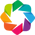

FineST version: 0.1.2
CUDA is available. GPU: NVIDIA A100-PCIE-40GB


In [3]:
## From local
path = '/mnt/lingyu/nfs_share2/Python/'
os.chdir(str(path) + 'FineST/FineST/')
import FineST as fst
from FineST.utils import device
from FineST.datasets import dataset
import FineST.plottings as fstplt
print("FineST version: %s" %fst.__version__)

## install FineST package
# import FineST as fst
# from FineST.datasets import dataset
# import FineST.plottings as fstplt
# print("torch version: %s" %torch.__version__)
# print("FineST version: %s" %fst.__version__)

fst.setup_seed(666)
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [4]:
## Set path
path = '/mnt/lingyu/nfs_share2/Python/'
# os.chdir(f'{path}FineST/FineST/')
os.chdir(f'{path}FineST/FineST_demo/')    # here I use FineST_demo

## Set logging
model_folder = 'logging/'
dir_name = model_folder + datetime.now().strftime('%Y%m%d%H%M%S%f')
print('dir_name: ', dir_name)
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
    logger = fst.setup_logger(dir_name)

## Set parameter 
parameter_file_path = 'parameter/parameters_BRCA_virchow2.json'
with open(parameter_file_path,"r") as json_file:
    params = json.load(json_file)
logger.info("Load parameters:\n" + json.dumps(params, indent=2))

[2025-06-25 21:27:32] INFO - Load parameters:
{
  "n_encoder_hidden_matrix": 256,
  "n_encoder_hidden_image": 128,
  "n_encoder_latent": 128,
  "n_projection_hidden": 256,
  "n_projection_output": 128,
  "batch_size": 200,
  "batch_size_pair": 64,
  "n_encoder_layers": 2,
  "dropout_rate": 0,
  "training_epoch": 50,
  "inital_learning_rate": 0.25,
  "k_nearest_positives": 0,
  "temperature": 0.03,
  "n_input_image": 1280,
  "w1": 0,
  "w2": 0,
  "w3": 1,
  "w4": 1
}


dir_name:  logging/20250625212732949816


You can use the `parameter_file_path` you set or the optimal parameters obtained from your train and test model for your dataset, but here we use our trained `parameter_file_path` for paper results repeated (saved in `FineST/FineST/Parameter/parameters_NPC_P10125.json`).

## 1. Load ST data and Image embeddings

1.1 Load spatial data

A human Nasopharyngeal carcinoma dataset (NPC_patient_1) from [Gong, et al](https://www.nature.com/articles/s41467-023-37614-6). will be used as a reference dataset, raw_feature_bc_matrix, filtered_feature_bc_matrix, and spatial coordinates (.h5) are publicly available in [GSE200310](https://ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE200310). For easier reuse, we included them in an anndata object which can be loaded directly in FineST Python package.

In [5]:
# demo_data = 'BRCAhuman_data/' 
# adata = sc.read_visium(f'{demo_data}')

In [6]:
adata = dataset.BRCA()
print(adata)

AnnData object with n_obs × n_vars = 4992 × 18085
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


In FineST, we only considers 963 human genes involved in ligand-receptor pairs from [CellChatDB (version.1.1.3)](https://github.com/sqjin/CellChat/tree/master/data) (mouse: 2,022 pairs, human: 1,940 pairs, zebrafish: 2,774 pairs), and extract the overlap gene's expression profile.

In [7]:
## Selected LR genes. Here gene_list can be 'LR_genes', 'HV_genes' or 'LR_HV_genes'
adata = fst.adata_LR(adata, gene_list='LR_HV_genes', n_top_genes=100)

After making an intersection with the LR genes and filtering out genes that are detected in less than 10 cells, 596 genes from the NPC datasetare used for training and prediction.

In [8]:
adata_count = adata.copy()
adata = fst.adata_preprocess(adata_count, normalize=False)
adata

AnnData object with n_obs × n_vars = 4992 × 957
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

1.4 Order by image file name

python ./demo/Image_feature_extraction.py \
   --datasetBRCAC \
   --position_patBRCAhuman_datatial/tissue_positions_list.csv  \
   --rawimage_path BRCBRCAhuman_data-C-AH4199551.tif \
   --scale_image False \
   --method Virchow2 \
   --patch_size 112 \
   --output_img BRCAhBRCAhuman_datangs/pth_112_14_image \
   --output_pth BRCAhuman_BRCAhuman_datath_112_14 \
   --logging BRCAhuman_data/BRCAhuman_data

Load image embedding from **Setp0** `HIPT_image_feature_extract.py`. For NPC dataset, the image embedding file can be downloaded [Goole Drive](https://drive.google.com/drive/folders/1ypaTohLM2lP4EnKeYTS6QUvv-ymcRVZo) (within spots: AH_Patient1_pth_64_16, between spots: NEW_AH_Patient1_pth_64_16, single-nuclei: sc_Patient1_pth_16_16).

In [9]:
## Load ST spot position
demo_data = 'BRCAhuman_data/'
position = pd.read_csv(f'{demo_data}spatial/tissue_positions_list.csv', header=None)
position = position.rename(columns={position.columns[-2]: 'pixel_x', 
                                    position.columns[-1]: 'pixel_y'})
print("The coords of ST spot: ", position.shape)

## Order spot position by image file name
file_paths = sorted(os.listdir(f'{demo_data}/ImgEmbeddings/Bpth_112_14/'))
print("Image embedding file: ", file_paths[:3])

## Get patch position and merge position
position_image = fst.get_image_coord(file_paths, dataset_class="Visium")
position_image = fst.image_coord_merge(position_image, position, dataset_class = 'Visium')
position_order = fst.update_st_coord(position_image)
print("The coords of image patch (merged): ", position_order.shape)
print(position_order.head())

## Save the position data  -- train model used
link_data = 'OrderData_HVLR/'
save_dir = os.path.join(demo_data, link_data)
os.makedirs(save_dir, exist_ok=True)  
position_order.to_csv(f'{demo_data}{link_data}position_order.csv', index=False, header=False)

## Order matrix row/barcode, spatial coordinates by image coordinates
spotID_order = np.array(position_image[0])
gene_hv = np.array(adata.var_names)
matrix_order, matrix_order_df = fst.sort_matrix(adata, position_image, spotID_order, gene_hv)

## Save gene expression mateix -- train model used
np.save(f'{demo_data}{link_data}matrix_order.npy', matrix_order_df.T)

The coords of ST spot:  (4992, 6)
Image embedding file:  ['BRCAhuman_10002_8086.pth', 'BRCAhuman_10004_8404.pth', 'BRCAhuman_10007_8722.pth']
The coords of image patch (merged):  (4992, 4)
   pixel_y  pixel_x  array_row  array_col
0    10002     8086         58         22
1    10004     8404         58         24
2    10007     8722         58         26
3    10009     9039         58         28
4    10011     9357         58         30
(4992, 957)


1.5 Order matrix row/barcode, spatial coordinates by image coordinates

In [10]:
## Update adata with new barcodes and lications
adata = fst.update_adata_coord(adata, matrix_order_df, position_image)
print(adata)
adata_count = adata.copy()
adata_norml = fst.adata_preprocess(adata.copy(), normalize=True)

## Save adata
save_data = 'SaveData_HVLR/'
save_dir = os.path.join(demo_data, save_data)
os.makedirs(save_dir, exist_ok=True)  
adata_count.write_h5ad(f'{demo_data}{save_data}adata_count.h5ad')
adata_norml.write_h5ad(f'{demo_data}{save_data}adata_norml.h5ad')

AnnData object with n_obs × n_vars = 4992 × 957
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'


<div class="alert alert-info">

**Note**
The above cells for `section 1.5` only need to be run once. They aim to generate the ordered gene expression profile `harmony_matrix.npy` and the ordered ST spot coordinates `position_order.csv` according to image pixel coordinates, and save the normalized gene expression data `patient1_adata_orignal`. 

</div>

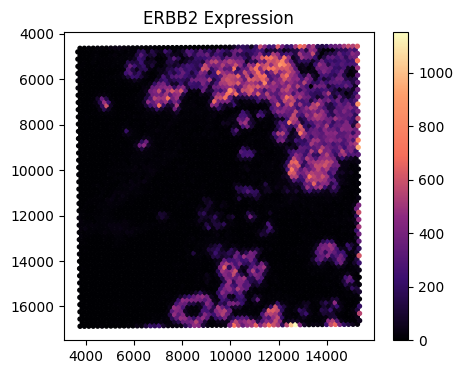

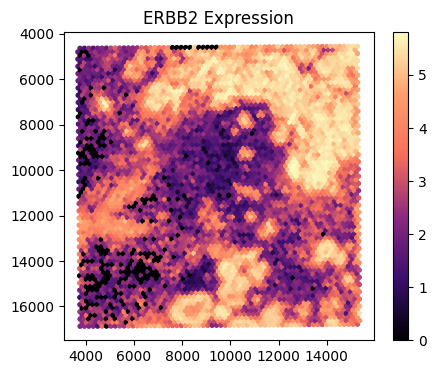

In [11]:
fig_path = 'Figures_HVLR/'
save_dir = os.path.join(demo_data, fig_path)
os.makedirs(save_dir, exist_ok=True)  

fstplt.gene_expr(adata_count, adata_count.to_df(), gene_selet='ERBB2', marker='o', 
                 s=8, figsize=(5, 4), save_path=f'{demo_data}{fig_path}/ERBB2_expr_count.pdf')
fstplt.gene_expr(adata_norml, adata_norml.to_df(), gene_selet='ERBB2', marker='o', 
                 s=8, figsize=(5, 4), save_path=f'{demo_data}{fig_path}/ERBB2_expr_norml.pdf')

## 2. Train model and Internal validation

In [12]:
image_embed_path = f'{demo_data}ImgEmbeddings/Bpth_112_14/*.pth' 
spatial_pos_path = f'{demo_data}{link_data}position_order.csv'
reduced_mtx_path = f'{demo_data}{link_data}/matrix_order.npy'

In [13]:
# ## add params
# params['n_input_matrix'] = len(gene_hv)

# ## init the model
# model = fst.FineSTModel(n_input_matrix=params['n_input_matrix'],
#                               n_input_image=params['n_input_image'],
#                               n_encoder_hidden_matrix=params["n_encoder_hidden_matrix"],
#                               n_encoder_hidden_image=params["n_encoder_hidden_image"],
#                               n_encoder_latent=params["n_encoder_latent"],
#                               n_projection_hidden=params["n_projection_hidden"],
#                               n_projection_output=params["n_projection_output"],
#                               n_encoder_layers=params["n_encoder_layers"]).to(device) 
# ## Load the data
# train_loader, test_loader = fst.build_loaders(batch_size=params['batch_size'], 
#                                               image_embed_path=image_embed_path, 
#                                               spatial_pos_path=spatial_pos_path, 
#                                               reduced_mtx_path=reduced_mtx_path, 
#                                               image_clacss='Virchow2',
#                                               dataset_class='Visium64') 
# ## Set optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=params['inital_learning_rate'], 
#                             momentum=0.9, weight_decay=5e-4)
# ## Load loss function
# l = fst.ContrastiveLoss(temperature=params['temperature'], 
#                         w1=params['w1'], w2=params['w2'], w3=params['w3'], w4=params['w4'])

# ## train model
# (dir_name, 
#  train_losses, test_losses, 
#  best_epoch, best_loss) = fst.train_model_fst(params, model, train_loader, test_loader, 
#                                           optimizer, l, dir_name, logger, dataset_class='Visium64')

CUDA is available. GPU: NVIDIA A100-PCIE-40GB
Finished loading all files
train/test split completed
3993 999
***** Finished building loaders *****


[2025-06-23 22:40:33] INFO - Begin Training ...
[2025-06-23 22:40:33] INFO - epoch [1/50]


Epoch: 1
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 85.75it/s]


--- 111.71955800056458 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 75.42it/s]
[2025-06-23 22:42:30] INFO - Best epoch_loss: [0: 1.4279]
[2025-06-23 22:42:30] INFO - epoch [2/50]


Epoch: 2
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 85.52it/s]


--- 107.66570448875427 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 93.15it/s]
[2025-06-23 22:44:23] INFO - Best epoch_loss: [1: 1.3576]
[2025-06-23 22:44:23] INFO - epoch [3/50]


Epoch: 3
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 90.49it/s]


--- 108.49555349349976 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 86.23it/s]
[2025-06-23 22:46:16] INFO - Best epoch_loss: [2: 1.3011]
[2025-06-23 22:46:16] INFO - epoch [4/50]


Epoch: 4
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 88.26it/s]


--- 108.18525719642639 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 89.22it/s]
[2025-06-23 22:48:10] INFO - Best epoch_loss: [3: 1.2525]
[2025-06-23 22:48:10] INFO - epoch [5/50]


Epoch: 5
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 85.81it/s]


--- 108.38071298599243 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 79.30it/s]
[2025-06-23 22:50:04] INFO - Best epoch_loss: [4: 1.2249]
[2025-06-23 22:50:04] INFO - epoch [6/50]


Epoch: 6
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 90.31it/s]


--- 108.92474460601807 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 83.67it/s]
[2025-06-23 22:51:59] INFO - Best epoch_loss: [5: 1.2180]
[2025-06-23 22:51:59] INFO - epoch [7/50]


Epoch: 7
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 84.51it/s]


--- 108.75559973716736 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 87.62it/s]
[2025-06-23 22:53:53] INFO - epoch [8/50]


Epoch: 8
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 84.83it/s]


--- 109.41820359230042 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 85.80it/s]
[2025-06-23 22:55:48] INFO - Best epoch_loss: [7: 1.2142]
[2025-06-23 22:55:48] INFO - epoch [9/50]


Epoch: 9
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 92.23it/s]


--- 108.75098657608032 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 91.47it/s]
[2025-06-23 22:57:43] INFO - Best epoch_loss: [8: 1.2019]
[2025-06-23 22:57:43] INFO - epoch [10/50]


Epoch: 10
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 90.03it/s]


--- 107.55674171447754 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 79.42it/s]
[2025-06-23 22:59:36] INFO - Best epoch_loss: [9: 1.1995]
[2025-06-23 22:59:36] INFO - epoch [11/50]


Epoch: 11
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 92.00it/s]


--- 108.15278124809265 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 92.74it/s]
[2025-06-23 23:01:30] INFO - Best epoch_loss: [10: 1.1883]
[2025-06-23 23:01:30] INFO - epoch [12/50]


Epoch: 12
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 88.73it/s]


--- 108.17965912818909 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 91.68it/s]
[2025-06-23 23:03:23] INFO - Best epoch_loss: [11: 1.1880]
[2025-06-23 23:03:23] INFO - epoch [13/50]


Epoch: 13
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 87.73it/s]


--- 107.62192392349243 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 91.42it/s]
[2025-06-23 23:05:17] INFO - Best epoch_loss: [12: 1.1767]
[2025-06-23 23:05:17] INFO - epoch [14/50]


Epoch: 14
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 90.05it/s]


--- 107.96711659431458 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 88.53it/s]
[2025-06-23 23:07:10] INFO - epoch [15/50]


Epoch: 15
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 92.76it/s]


--- 108.31954026222229 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 83.55it/s]
[2025-06-23 23:09:03] INFO - epoch [16/50]


Epoch: 16
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 85.53it/s]


--- 109.51529741287231 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 85.79it/s]
[2025-06-23 23:10:58] INFO - Best epoch_loss: [15: 1.1733]
[2025-06-23 23:10:58] INFO - epoch [17/50]


Epoch: 17
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 94.04it/s]


--- 112.46315050125122 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 92.12it/s]
[2025-06-23 23:12:56] INFO - epoch [18/50]


Epoch: 18
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 89.31it/s]


--- 112.30826568603516 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 88.25it/s]
[2025-06-23 23:14:54] INFO - epoch [19/50]


Epoch: 19
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 89.56it/s]


--- 112.17723894119263 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 76.05it/s]
[2025-06-23 23:16:52] INFO - Best epoch_loss: [18: 1.1711]
[2025-06-23 23:16:52] INFO - epoch [20/50]


Epoch: 20
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 90.59it/s]


--- 111.77022004127502 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 92.40it/s]
[2025-06-23 23:18:49] INFO - Best epoch_loss: [19: 1.1660]
[2025-06-23 23:18:49] INFO - epoch [21/50]


Epoch: 21
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 94.99it/s]


--- 111.41425228118896 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 91.78it/s]
[2025-06-23 23:20:46] INFO - Best epoch_loss: [20: 1.1598]
[2025-06-23 23:20:46] INFO - epoch [22/50]


Epoch: 22
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 88.77it/s]


--- 112.29117393493652 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 82.74it/s]
[2025-06-23 23:22:44] INFO - Best epoch_loss: [21: 1.1558]
[2025-06-23 23:22:44] INFO - epoch [23/50]


Epoch: 23
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 85.84it/s]


--- 111.61998462677002 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 93.06it/s]
[2025-06-23 23:24:41] INFO - Best epoch_loss: [22: 1.1534]
[2025-06-23 23:24:41] INFO - epoch [24/50]


Epoch: 24
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 93.37it/s]


--- 111.8719129562378 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 91.46it/s]
[2025-06-23 23:26:39] INFO - Best epoch_loss: [23: 1.1511]
[2025-06-23 23:26:39] INFO - epoch [25/50]


Epoch: 25
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 90.09it/s]


--- 111.5848035812378 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 81.35it/s]
[2025-06-23 23:28:36] INFO - epoch [26/50]


Epoch: 26
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 84.97it/s]


--- 110.41989159584045 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 91.49it/s]
[2025-06-23 23:30:32] INFO - epoch [27/50]


Epoch: 27
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 90.35it/s]


--- 111.02134275436401 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 89.39it/s]
[2025-06-23 23:32:28] INFO - epoch [28/50]


Epoch: 28
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 93.39it/s]


--- 111.35511302947998 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 89.98it/s]
[2025-06-23 23:34:25] INFO - Best epoch_loss: [27: 1.1475]
[2025-06-23 23:34:25] INFO - epoch [29/50]


Epoch: 29
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 94.48it/s]


--- 112.02039313316345 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 88.88it/s]
[2025-06-23 23:36:22] INFO - epoch [30/50]


Epoch: 30
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 93.31it/s]


--- 110.75936079025269 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 89.59it/s]
[2025-06-23 23:38:19] INFO - Best epoch_loss: [29: 1.1467]
[2025-06-23 23:38:19] INFO - epoch [31/50]


Epoch: 31
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 80.16it/s]


--- 109.36541080474854 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 76.40it/s]
[2025-06-23 23:40:14] INFO - Best epoch_loss: [30: 1.1443]
[2025-06-23 23:40:14] INFO - epoch [32/50]


Epoch: 32
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 84.47it/s]


--- 109.58969593048096 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 92.05it/s]
[2025-06-23 23:42:09] INFO - Best epoch_loss: [31: 1.1428]
[2025-06-23 23:42:09] INFO - epoch [33/50]


Epoch: 33
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 88.81it/s]


--- 109.64148664474487 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 82.64it/s]
[2025-06-23 23:44:03] INFO - Best epoch_loss: [32: 1.1416]
[2025-06-23 23:44:03] INFO - epoch [34/50]


Epoch: 34
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 90.60it/s]


--- 107.17861580848694 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 68.30it/s]
[2025-06-23 23:45:56] INFO - Best epoch_loss: [33: 1.1410]
[2025-06-23 23:45:56] INFO - epoch [35/50]


Epoch: 35
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 93.79it/s]


--- 109.8013174533844 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 89.62it/s]
[2025-06-23 23:47:51] INFO - Best epoch_loss: [34: 1.1397]
[2025-06-23 23:47:51] INFO - epoch [36/50]


Epoch: 36
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 87.64it/s]


--- 110.21146774291992 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 91.51it/s]
[2025-06-23 23:49:47] INFO - Best epoch_loss: [35: 1.1365]
[2025-06-23 23:49:47] INFO - epoch [37/50]


Epoch: 37
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 75.98it/s]


--- 110.30329751968384 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 90.03it/s]
[2025-06-23 23:51:44] INFO - epoch [38/50]


Epoch: 38
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 79.41it/s]


--- 107.1754674911499 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 92.86it/s]
[2025-06-23 23:53:36] INFO - epoch [39/50]


Epoch: 39
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 92.99it/s]


--- 106.85993933677673 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 91.55it/s]
[2025-06-23 23:55:28] INFO - Best epoch_loss: [38: 1.1309]
[2025-06-23 23:55:28] INFO - epoch [40/50]


Epoch: 40
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 85.36it/s]


--- 104.71173787117004 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 91.34it/s]
[2025-06-23 23:57:18] INFO - Best epoch_loss: [39: 1.1293]
[2025-06-23 23:57:18] INFO - epoch [41/50]


Epoch: 41
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 94.49it/s]


--- 104.87826538085938 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 92.03it/s]
[2025-06-23 23:59:09] INFO - epoch [42/50]


Epoch: 42
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 92.45it/s]


--- 104.40178179740906 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 91.24it/s]
[2025-06-24 00:00:58] INFO - epoch [43/50]


Epoch: 43
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 88.52it/s]


--- 105.54274106025696 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 89.74it/s]
[2025-06-24 00:02:49] INFO - epoch [44/50]


Epoch: 44
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 89.57it/s]


--- 103.46727180480957 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 89.55it/s]
[2025-06-24 00:04:38] INFO - Best epoch_loss: [43: 1.1271]
[2025-06-24 00:04:38] INFO - epoch [45/50]


Epoch: 45
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 94.50it/s]


--- 105.12205028533936 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 93.04it/s]
[2025-06-24 00:06:29] INFO - Best epoch_loss: [44: 1.1236]
[2025-06-24 00:06:29] INFO - epoch [46/50]


Epoch: 46
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 91.06it/s]


--- 104.28770637512207 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 76.37it/s]
[2025-06-24 00:08:18] INFO - epoch [47/50]


Epoch: 47
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 86.68it/s]


--- 105.88702821731567 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 67.10it/s]
[2025-06-24 00:10:10] INFO - epoch [48/50]


Epoch: 48
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 89.30it/s]


--- 106.16668939590454 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 80.74it/s]
[2025-06-24 00:12:01] INFO - epoch [49/50]


Epoch: 49
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 91.67it/s]


--- 105.84191489219666 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 84.89it/s]
[2025-06-24 00:13:53] INFO - epoch [50/50]


Epoch: 50
train model


100%|██████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 84.41it/s]


--- 105.05364155769348 seconds ---
test model


100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 69.40it/s]
[2025-06-24 00:15:43] INFO - Done!, Best epoch_loss: [44: 1.1236]
[2025-06-24 00:15:43] INFO - Finished Training


Done!, Best epoch_loss: [44: 1.1236]
Training epoch time: 5709.9951 seconds


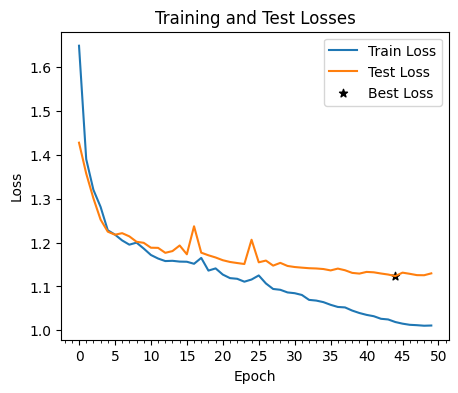

In [14]:
fst.loss_curve(train_losses, test_losses, best_epoch, best_loss, max_step=5, min_step=1, 
               fig_size=(5, 4), format='svg', save_path=f'{demo_data}{fig_path}NPC_loss_curve.svg')

2.1 Data loader and splitting: 80% for train and 20% for test

Input: three input file pathway: \
    - `image_embed_path`: image embedding from **Setp0** `HIPT_image_feature_extract.py` \
    - `spatial_pos_path`: ordered ST spot coords, in `./Dataset/BRCA/ContrastgeneLR/position_order.csv` \
    - `reduced_mtx_path`: ordered gene expression, in `./Dataset/BRCA/ContrastgeneLR/harmony_matrix.np` 

For NPC dataset, the image embedding file can be downloaded [Goole Drive](https://drive.google.com/drive/folders/1ypaTohLM2lP4EnKeYTS6QUvv-ymcRVZo).

<div class="alert alert-info">

**Note**
The above cell for `section 2.2` needs to be run more than once by setting different parameters in the given `.json` file, if the correlation in `section 3.4` is not satisfying. If one obtains a good performance, one can save the `dir_name` and then directly use it to load the trained model and infer gene expression, and doesn't need to run `section 2.2` again. Recommended parameter fine-tuning and its range: `training_epoch`: 40~60; 
`temperature`: 0.01-0.05.

</div>

## 3. Inference, Imputation and Evaluation on within spot

3.1 Infer the gene expression of within spots

In [15]:
dir_name

'logging/20250623224015573616'

You can use the `dir_name` just obtained from the above cell, but here we use our trained `dir_name` for paper results repeated (saved in `FineST/FineST/Finetune/20250623164127888297`).

In [13]:
# dir_name = 'logging/20250623164127888297'    # for HV_LR_gene500 
# dir_name = 'logging/20250623194133347124'    # for HV_LR_gene200 
dir_name = 'logging/20250623224015573616'    # for HV_LR_gene100 
# dir_name = 'logging/20250609222943565099'    # for LR_gene 

In [14]:
## Load the trained model
model = fst.load_model(dir_name, parameter_file_path, gene_hv)

## Load test data
test_loader = fst.build_loaders_inference(batch_size=adata.shape[0], 
                                          image_embed_path=image_embed_path, 
                                          spatial_pos_path=spatial_pos_path, 
                                          reduced_mtx_path=reduced_mtx_path,
                                          image_clacss='Virchow2',
                                          dataset_class='Visium64')
## Inference
(matrix_profile,
 reconstructed_matrix, 
 recon_ref_adata_image_f2, 
 reconstructed_matrix_reshaped, 
 input_coord_all) = fst.infer_model_fst(model, test_loader, logger, dataset_class='Visium64')

CUDA is available. GPU: NVIDIA A100-PCIE-40GB


[2025-06-24 11:51:38] INFO - Running inference task...


Finished loading all files
***** Finished building loaders_inference *****
device cuda:2
***** Begin perform_inference: ******


100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


***** batch_size=adata.shape[0] doen't effect *****
torch.Size([4992, 957])
torch.Size([4992, 64, 1280])
1
1
1
***** *****
Finished extractting test data


[2025-06-24 11:51:41] INFO - Running inference task DONE!


Inference within spots: 2.5363 seconds
Reconstructed_matrix_reshaped shape:  torch.Size([319488, 957])


We use `reshape_latent_image()` function to convert the super-resolved gene expression with 16X relolution `reconstructed_matrix_reshaped` (torch.Size([21296, 596])) into tensor format `reconstructed_matrix_reshaped_tensor` (torch.Size([1331, 16, 596])).

In [15]:
## Get the sub-spot level gene expression of all genes on all within-spots
reconstructed_matrix_reshaped_tensor, _ = fst.reshape_latent_image(reconstructed_matrix_reshaped, 
                                                                   dataset_class='Visium64')
(_, _, all_spot_all_variable,
 C2, adata_infer) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor,
                                                adata, gene_hv, patch_size=112, dataset_class='Visium64')
print(adata_infer)

_, adata_infer_reshape = fst.reshape_latent_image(torch.tensor(adata_infer.X), dataset_class='Visium64')
adata_infer_spot = fst.reshape2adata(adata, adata_infer_reshape, gene_hv)
print(adata_infer_spot)

## save adata
adata_infer.write_h5ad(f'{demo_data}{save_data}adata_infer.h5ad')    # adata 85184 × 596
adata_infer_spot.write_h5ad(f'{demo_data}{save_data}adata_infer_spot.h5ad')    # adata 1331 × 596

pixel_step (half of patch_size): 7.0
AnnData object with n_obs × n_vars = 319488 × 957
    obs: 'x', 'y'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 4992 × 957
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'


3.2 Get coordinates of sub-spots from within spots

pixel_step (half of patch_size): 7.0
first_spot_first_variable shape: (64,)


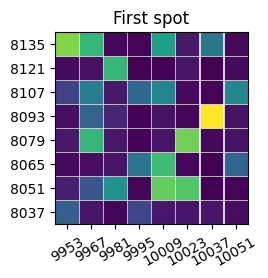

In [16]:
## Plot the first_spot_first_variable spiltting
(first_spot_first_variable, C,
 _, _, _) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor, adata, gene_hv, 
                                         p=0, q=0, patch_size=112, dataset_class='Visium64')
print("first_spot_first_variable shape:", first_spot_first_variable.shape)

fstplt.subspot_expr(C, first_spot_first_variable, patch_size=112, dataset_class='Visium64', 
                     marker='s', s=250, rotation=30, fig_size=(2.5, 2.5), format='svg', 
                    save_path=f'{demo_data}{fig_path}spot_splitting.svg')

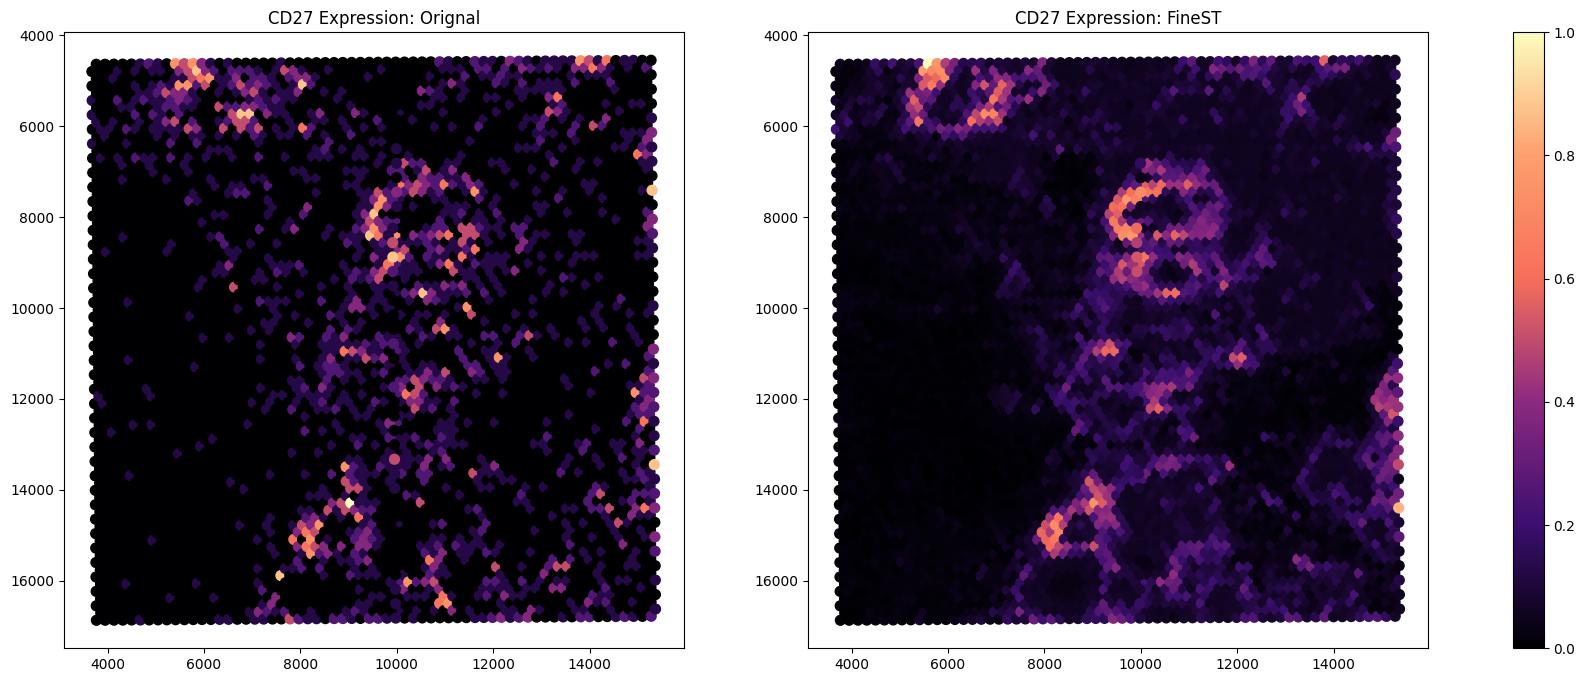

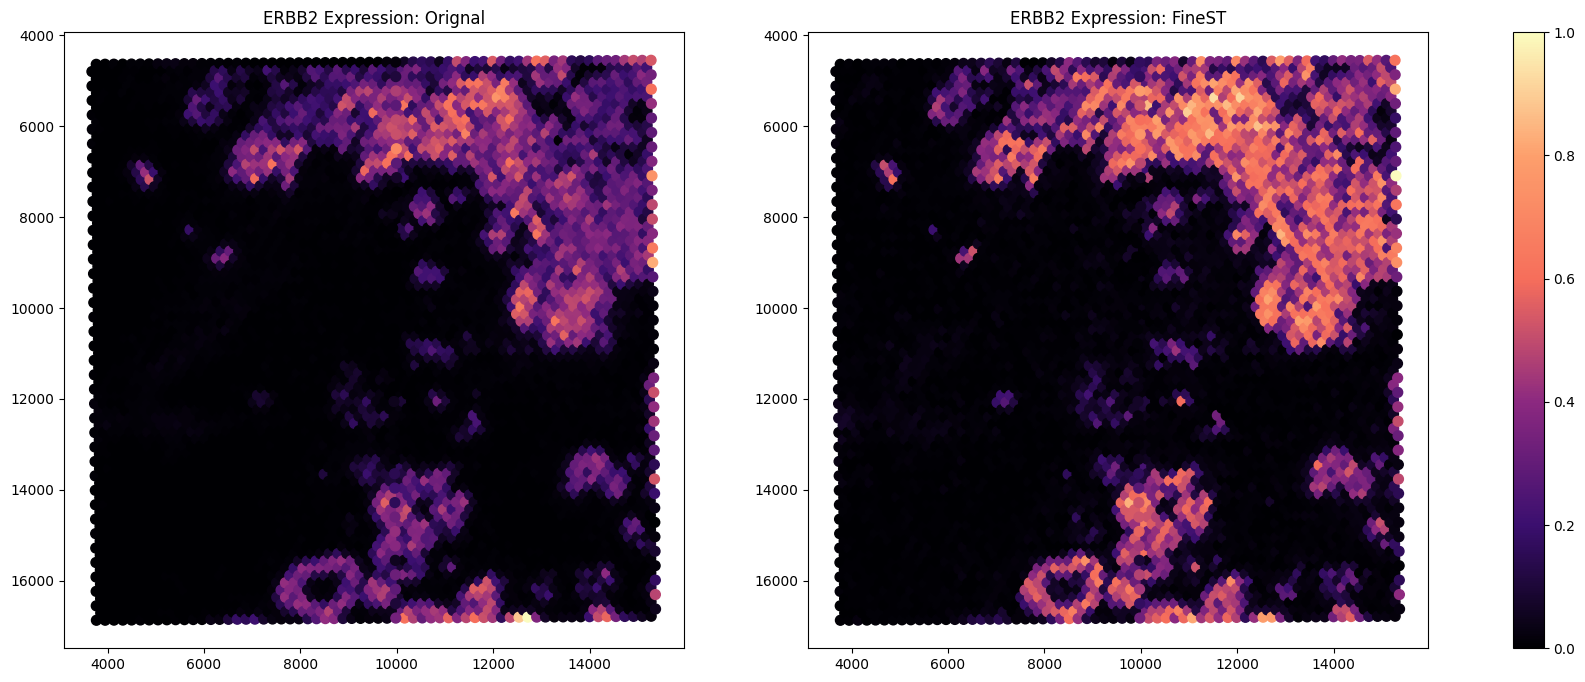

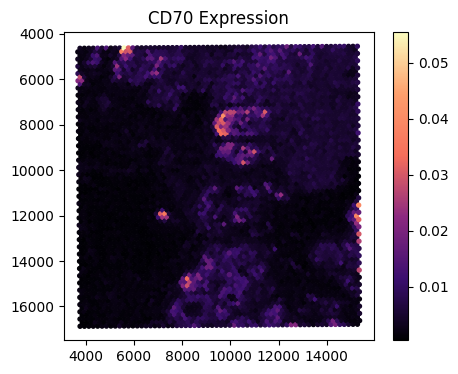

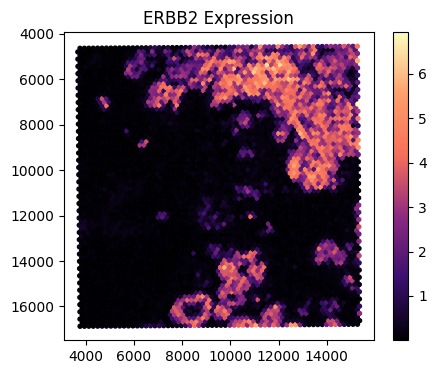

In [17]:
## Show marker gene expression -- only infer from image
fstplt.gene_expr_compare(adata, "CD27", adata_infer_reshape, gene_hv, s=50, save_path=None)
fstplt.gene_expr_compare(adata, "ERBB2", adata_infer_reshape, gene_hv, s=50, save_path=None)

fstplt.gene_expr(adata, adata_infer_reshape, gene_selet='CD70', marker='o', 
                 s=8, figsize=(5, 4), save_path=f'{demo_data}{fig_path}CD70_expr_infer_spot_within.pdf')
fstplt.gene_expr(adata, adata_infer_reshape, gene_selet='ERBB2', marker='o', 
                 s=8, figsize=(5, 4), save_path=f'{demo_data}{fig_path}ERBB2_expr_infer_spot_within.pdf')

mean correlation of spots:  0.9246032651501169
mean correlation of genes:  0.422040965461441


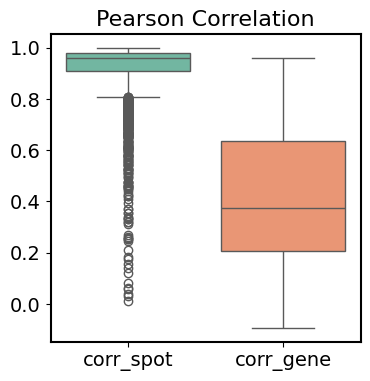

mean correlation of spots:  0.5641328449527827
mean correlation of genes:  0.2160044059802268


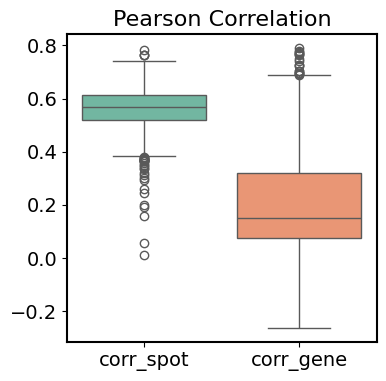

In [18]:
## save the correlation -- -- only infer from image
fstplt.mean_cor_box(adata, adata_infer_reshape, save_path=f'{demo_data}{fig_path}Boxplot_infer_cor_count.pdf')
fstplt.mean_cor_box(adata_norml, adata_infer_reshape, save_path=f'{demo_data}{fig_path}Boxplot_infer_cor_norml.pdf')

Pearson correlations:  0.42204096546144093


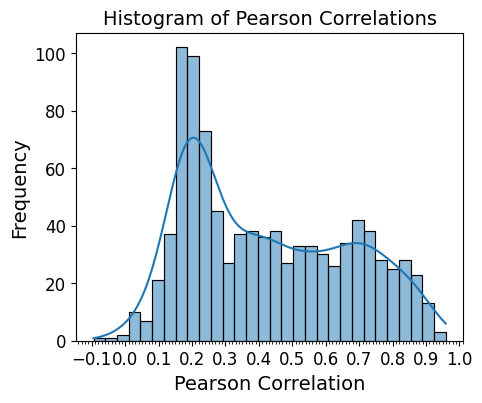

In [19]:
## Pearson correlations
fstplt.cor_hist(adata, adata_infer_spot.to_df(), 
                 fig_size=(5, 4), trans=False, format='svg', 
                 save_path=f'{demo_data}{fig_path}Hist_infer_cor_count.svg')

3.3 Impute the gene expression of sub-spots

Input: two input files: \
    - `adata`: original spot-level gene expression data (within spots). \
    - `adata_infer`: inferred super-resolved gene expression data (within spots). 

Input: three input files: \
    - `sudo_adata`: Imputed data using the nearest `k` neighbors of within spots (here `k=6`). \
    - `adata_impt`: `= w*adata_infer + (1-w)*sudo_adata`, predicted super-resolved gene expression data (here ` w=0.5`).\
    - ` data_impt`: predicted super-resolved gene expression data in tensor form (within spots).

In [20]:
# adata_smooth = fst.impute_adata(adata, adata_infer, C2, gene_hv, 
#                                 dataset_class='Visium64', weight_exponent=2)
adata_smooth = fst.impute_adata(adata_norml, adata_infer, C2, gene_hv, 
                                dataset_class='Visium64', weight_exponent=2)
print(adata_smooth)

Smoothing time: 103.8838 seconds
AnnData object with n_obs × n_vars = 319488 × 957
    obs: 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'


In [21]:
adata_imput, data_impt = fst.weight_adata(adata_infer, adata_smooth, gene_hv, w=0.8)
print(adata_imput)

_, data_impt_reshape = fst.reshape_latent_image(data_impt, dataset_class='Visium64')
adata_imput_spot = fst.reshape2adata(adata, data_impt_reshape, gene_hv)
print(adata_imput_spot)

## save adata
adata_imput.write_h5ad(f'{demo_data}{save_data}_adata_imput.h5ad')    # adata: 85184 × 596
adata_imput_spot.write_h5ad(f'{demo_data}{save_data}adata_imput_spot.h5ad')    # adata: 1331 × 596

AnnData object with n_obs × n_vars = 319488 × 957
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 4992 × 957
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'


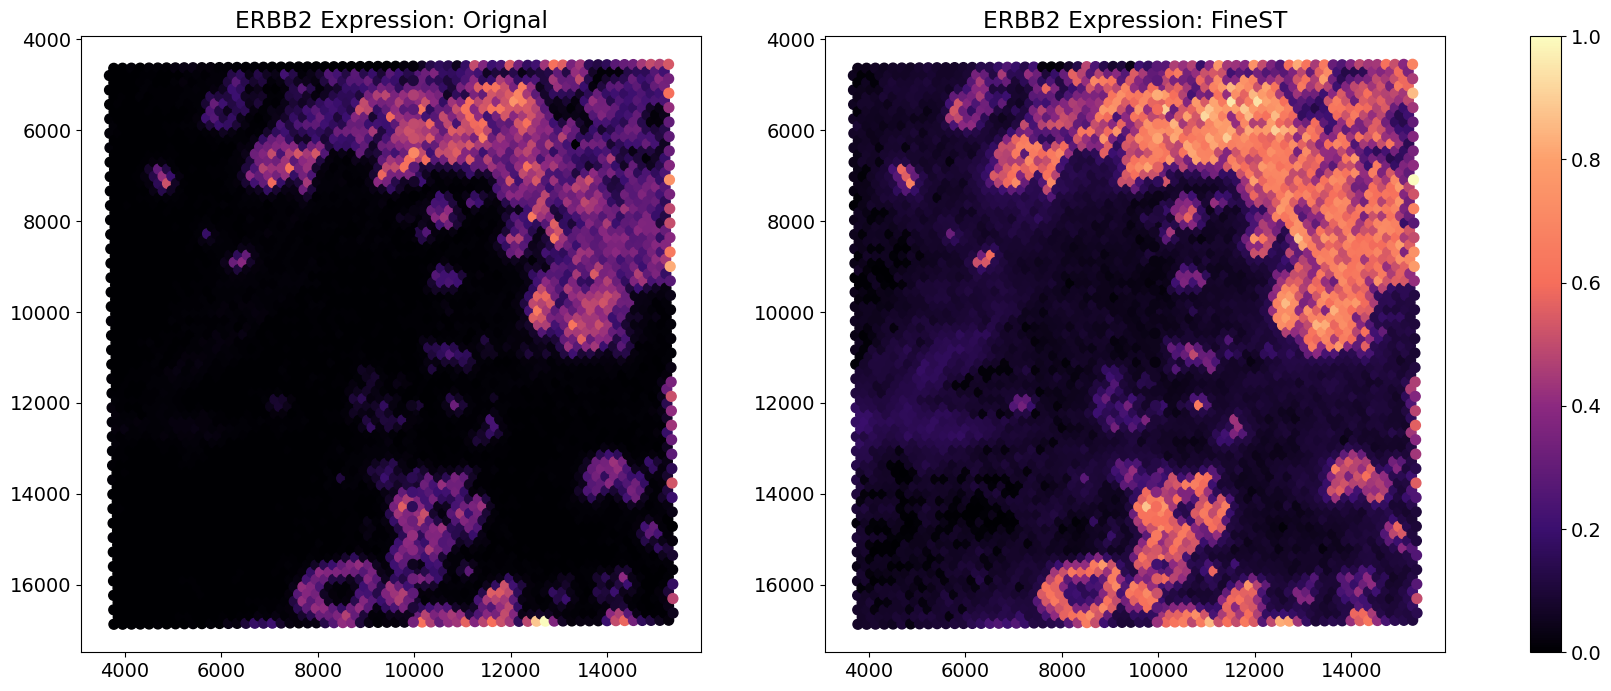

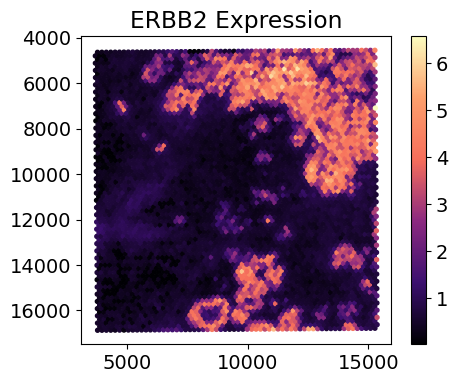

In [22]:
fstplt.gene_expr_compare(adata, "ERBB2", data_impt_reshape, gene_hv, s=50, save_path=None)

fstplt.gene_expr(adata, data_impt_reshape, gene_selet='ERBB2', marker='o', 
                 s=8, figsize=(5, 4), save_path=f'{demo_data}{fig_path}ERBB2_expr_imput_spot_within.pdf')

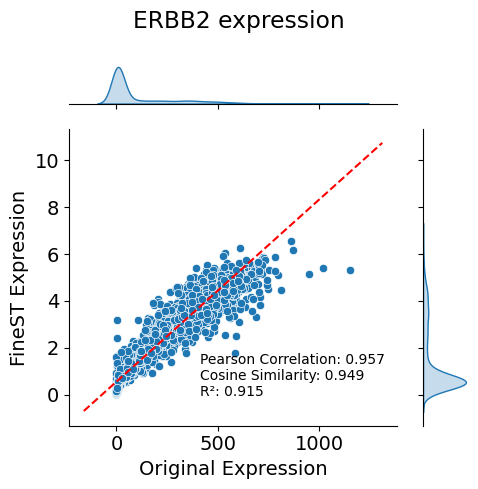

In [23]:
fstplt.sele_gene_cor(adata, data_impt_reshape, gene_hv, gene = "ERBB2", 
                     ylabel='FineST Expression', title = "ERBB2 expression", size=5, 
                     save_path=f'{demo_data}{fig_path}ERBB2_cor_imput_spot_within.pdf') 

In [24]:
logger.info("Running Gene Correlation task...")
(pearson_cor_gene, 
 spearman_cor_gene, 
 cosine_sim_gene) = fst.mean_cor(adata, data_impt_reshape, 'reconf2', sample="gene")
logger.info("Running Gene Correlation task DINE!")

[2025-06-24 11:54:26] INFO - Running Gene Correlation task...


matrix1:  (4992, 957)
matrix2:  (4992, 957)
Mean Pearson correlation coefficient--reconf2: 0.8031


[2025-06-24 11:54:28] INFO - Running Gene Correlation task DINE!


Mean Spearman correlation coefficient--reconf2: 0.6055
Mean cosine similarity--reconf2: 0.8343


mean correlation of spots:  0.8343019977910683
mean correlation of genes:  0.8030893673636097


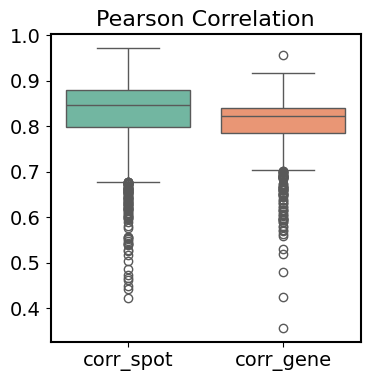

In [25]:
fstplt.mean_cor_box(adata, data_impt_reshape, save_path=f'{demo_data}{fig_path}Boxplot_imput_cor_count.pdf')

In [26]:
#####################
# release GUP memory
#####################
fst.release_gpu_tensors(globals())
# release_gpu_tensors(locals())    # If inside a function or class method

Releasing the following GPU tensors:
reconstructed_matrix_reshaped  1166.34 MB  shape=(319488, 957)
reconstructed_matrix_reshaped_tensor  1166.34 MB  shape=(4992, 64, 957)
Released GPU memory occupied by the above variables.


<div class="alert alert-info">

**Note**
Here the `adata_impt` is the imputed spot-level gene expression from FineST, it only contains the given 1331 within spots. The comparisons are based on the original adata `patient1_adata_orignal.h5ad` vs. FineST's predicted adata `patient1_adata.h5ad`.

</div>

## 4. Infer gene expression of "within spot" and "between spot" 

4.1 Get all spot coordinates (within spot & between spot) of image embeddings

Input: two input file pathways: \
    - `file_paths_spot`: image embedding, of within spots, from **Setp0** `HIPT_image_feature_extract.py`. \
    - `file_paths_between_spot`: image embedding, of between spots,  from **Setp0** `HIPT_image_feature_extract.py`. 

For NPC dataset, the image embedding file can be downloaded [Goole Drive](https://drive.google.com/drive/folders/1ypaTohLM2lP4EnKeYTS6QUvv-ymcRVZo).

time python ./FineST/demo/Image_feature_extraction.py \
   --dataset NEW_BRCAhuman \
   --position /mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Dataset/BRCA/BRCAhuman/BRCAhuman_position_add_tissue.csv \
   --imagefile /mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Dataset/BRCA/BRCAhuman/GSM7782699_tissue_image.tif \
   --scale_image False \
   --method Virchow2 \
   --output_path_img /mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Dataset/BRCA/HIPT/NEW_BRCAhuman_pth_112_14_image \
   --output_path_pth /mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Dataset/BRCA/HIPT/NEW_BRCAhuman_pth_112_14 \
   --patch_size 112 \
   --logging_folder /mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Logging/HIPT_BRCA/

real    6m55.316s
user    118m31.466s
sys     0m36.677s

In [13]:
# Add coords for each .pth file
file_paths_spot = os.listdir(f'{demo_data}ImgEmbeddings/Bpth_112_14/')
file_paths_between_spot = os.listdir(f'{demo_data}ImgEmbeddings/NEW_pth_112_14/')

file_paths_all = file_paths_spot + file_paths_between_spot
print("file_paths_spot number: ", len(file_paths_spot))
print("file_paths_between_spot number:", len(file_paths_between_spot))
print("file_paths_all number:", len(file_paths_all))

## Merge, sort and process file paths
data_all = fst.get_image_coord_all(file_paths_all)
position_order_allspot = pd.DataFrame(data_all, columns=['pixel_y', 'pixel_x'])

## save all spots
position_order_allspot.to_csv(f'{demo_data}{link_data}position_order_all.csv', index=False, header=False)

file_paths_spot number:  4992
file_paths_between_spot number: 14740
file_paths_all number: 19732


<div class="alert alert-info">

**Note**
The above two cells for `section 4.1` only need to be run once, aiming to generate the ordered ST spot coordinates `position_order_all.csv` according to image pixel coordinates.

</div>

4.2 Load all spot image embeddings with their coordinates

Input: three input file pathway: \
    - `file_paths_spot`: image embedding, of within spots, from **Setp0** `HIPT_image_feature_extract.py`. \
    - `file_paths_between_spot`: image embedding, of between spots,  from **Setp0** `HIPT_image_feature_extract.py`. \
    - `spatial_pos_path`: ordered all ST spot coordinates from above cell, can be found in `FineST/Dataset/BRCA/ContrastgeneLR/position_order_all.csv`

For NPC dataset, the image embedding file can be downloaded [Goole Drive](https://drive.google.com/drive/folders/1ypaTohLM2lP4EnKeYTS6QUvv-ymcRVZo).

In [14]:
import glob
file_paths_spot = f'{demo_data}ImgEmbeddings/Bpth_112_14/*.pth'
file_paths_between_spot = f'{demo_data}ImgEmbeddings/NEW_pth_112_14/*.pth'
spatial_pos_path=f'{demo_data}{link_data}position_order_all.csv'

In [15]:
# dir_name = 'logging/20250623164127888297'    # for HV_LR_gene500 
# dir_name = 'logging/20250623194133347124'    # for HV_LR_gene200 
dir_name = 'logging/20250623224015573616'    # for HV_LR_gene100 
# dir_name = 'logging/20250609222943565099'    # for LR_gene 

4.4 Load the trained model to infer all spots

In [16]:
## Load the trained model
model = fst.load_model(dir_name, parameter_file_path, gene_hv)

## load all spot (within and between) spots data
all_dataset = fst.build_loaders_inference_allimage(batch_size=len(file_paths_all), 
                                                   file_paths_spot=file_paths_spot, 
                                                   file_paths_between_spot=file_paths_between_spot, 
                                                   spatial_pos_path=spatial_pos_path, 
                                                   dataset_class='Visium64')

CUDA is available. GPU: NVIDIA A100-PCIE-40GB
***** Building loaders_inference between spot *****
Finished loading all files
***** Finished building loaders_inference *****


In [17]:
## inference
logger.info("Running inference tesk between spot...")
start_time = time.time()
(recon_ref_adata_image_f2, 
reconstructed_matrix_reshaped,
representation_image_reshape_between_spot,
input_image_exp_between_spot,
input_coord_all) = fst.perform_inference_image_between_spot(model, all_dataset, dataset_class='Visium64')
print("--- %s seconds ---" % (time.time() - start_time))

## print
print("recon_ref_adata_image_f2:", recon_ref_adata_image_f2.shape)
logger.info("Running inference tesk between spot DONE!")

[2025-06-24 14:02:52] INFO - Running inference tesk between spot...


device cuda:0
***** Begin perform_inference: ******


100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


***** batch_size=adata.shape[0] *****
torch.Size([19732, 64, 1280])
1
Finished extractting image_between_spot data


[2025-06-24 14:02:53] INFO - Running inference tesk between spot DONE!


--- 1.0904839038848877 seconds ---
recon_ref_adata_image_f2: (19732, 957)


4.5 Visualization all spots

In [18]:
## process_and_check_duplicates of the coordinates of all spots (within and between)
spatial_loc_all = fst.get_allspot_coors(input_coord_all)
print(spatial_loc_all)

Are there any duplicate rows? : False
[[10002.   8086. ]
 [10004.   8404. ]
 [10007.   8722. ]
 ...
 [ 9998.  13568. ]
 [ 9998.   7609.5]
 [ 9999.5 13727. ]]


ERBB2 gene expression dim: (19732, 1)
ERBB2 gene expression: 
 [[0.00312199]
 [0.15343657]
 [0.04387172]
 ...
 [2.6789844 ]
 [0.0527865 ]
 [0.4853448 ]]


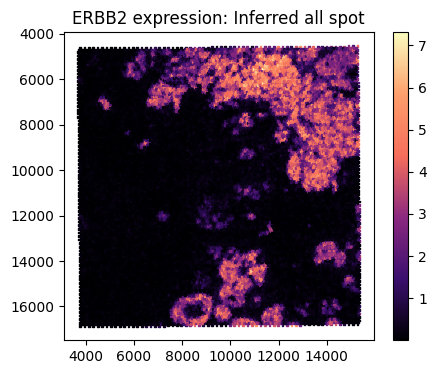

CD27 gene expression dim: (19732, 1)
CD27 gene expression: 
 [[0.02994157]
 [0.03847844]
 [0.0202886 ]
 ...
 [0.0080971 ]
 [0.04464841]
 [0.02626963]]


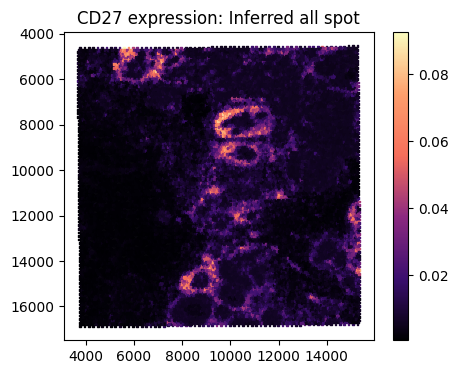

In [19]:
fstplt.gene_expr_allspots("ERBB2", spatial_loc_all, recon_ref_adata_image_f2, 
                          gene_hv, 'Inferred all spot', s=1.5, marker='s',
                          figsize=(5, 4), save_path=f'{demo_data}{fig_path}ERBB2_expr_infer_allspot.pdf')

fstplt.gene_expr_allspots("CD27", spatial_loc_all, recon_ref_adata_image_f2, 
                          gene_hv, 'Inferred all spot', s=1.5, marker='s',
                          figsize=(5, 4), save_path=f'{demo_data}{fig_path}CD27_expr_infer_allspot.pdf')

4.6 Visualization all sub-spots

In [20]:
## Get the sub-spot level gene expression of all genes in all spots
reconstructed_matrix_reshaped_tensor, _ = fst.reshape_latent_image(reconstructed_matrix_reshaped, 
                                                                   dataset_class='Visium64')
print("reconstructed_matrix_reshaped_tensor size: ", reconstructed_matrix_reshaped_tensor.shape)

(_, _, all_spot_all_variable, 
 C2, adata_infer_all) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor,
                                                    spatial_loc_all, gene_hv, patch_size=112, dataset_class="Visium64")
print(adata_infer_all)

reconstructed_matrix_reshaped_tensor size:  torch.Size([19732, 64, 957])
pixel_step (half of patch_size): 7.0
AnnData object with n_obs × n_vars = 1262848 × 957
    obs: 'x', 'y'
    obsm: 'spatial'


ERBB2 gene expression dim: (1262848, 1)
ERBB2 gene expression: 
 [[4.24751313e-03]
 [1.34309847e-03]
 [2.99839303e-05]
 ...
 [1.04712415e+00]
 [1.94275659e-03]
 [1.80224568e-01]]


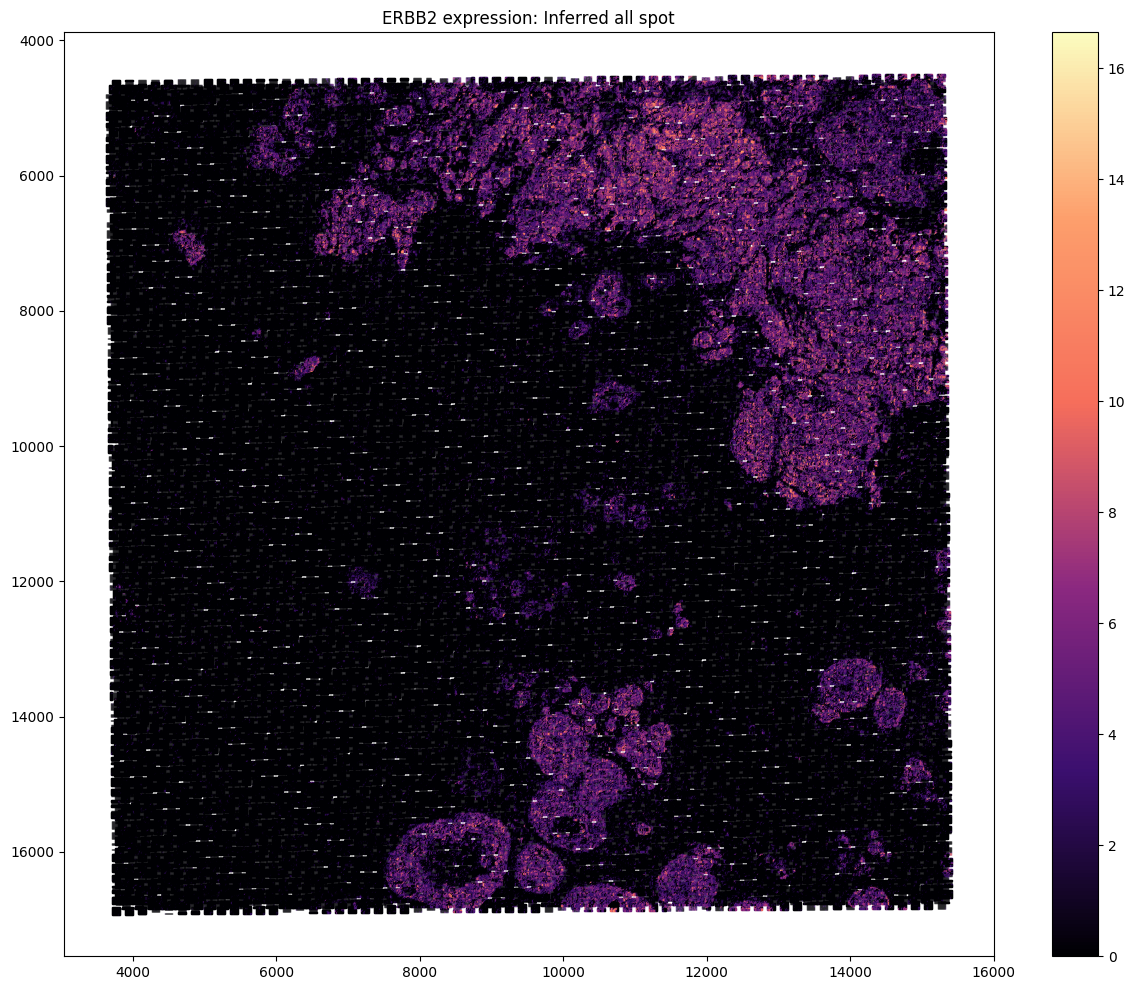

In [21]:
fstplt.gene_expr_allspots("ERBB2", C2, all_spot_all_variable, gene_hv, 
                           'Inferred all spot', marker='s', s=0.3, 
                          figsize=(15, 12), save_path=f'{demo_data}{fig_path}ERBB2_expr_infer_allsubspot.pdf')

In [23]:
#####################
# release GUP memory
#####################
fst.release_gpu_tensors(globals())
# release_gpu_tensors(locals())    # If inside a function or class method

Releasing the following GPU tensors:
input_image_exp_between_spot  6166.25 MB  shape=(1262848, 1280)
reconstructed_matrix_reshaped  4610.24 MB  shape=(1262848, 957)
reconstructed_matrix_reshaped_tensor  4610.24 MB  shape=(19732, 64, 957)
Released GPU memory occupied by the above variables.


## 5. Imputate sub-spot gene expression using measured spot expression

5.1 Impute the gene expression of all sub-spots from all spots (within spots and between spots)

Input: two input files: \
    - `adata`: original spot-level gene expression data (within spots). \
    - `adata_infer`: inferred super-resolved gene expression data (within spots). 

Input: three input files: \
    - `adata_impt`: `= w*adata_infer + (1-w)*sudo_adata`, predicted super-resolved gene expression data (here `w=0.5`).\
    - `sudo_adata`: Imputed data using the nearest `k` neighbors of within spots (here `k=6`). \
    - ` data_impt`: predicted super-resolved gene expression data in tensor form (within spots).

In [24]:
# adata_smooth_all = fst.impute_adata(adata, adata_infer_all, C2, gene_hv, dataset_class='Visium64', weight_exponent=2)
adata_smooth_all = fst.impute_adata(adata_norml, adata_infer_all, C2, gene_hv, dataset_class='Visium64', weight_exponent=2)
print(adata_smooth_all)

Smoothing time: 409.9588 seconds
AnnData object with n_obs × n_vars = 1262848 × 957
    obs: 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'


In [25]:
adata_impt_all, data_impt_all = fst.weight_adata(adata_infer_all, adata_smooth_all, gene_hv, w=0.8)  
print(adata_impt_all)

## save adata 
adata_impt_all.write_h5ad(f'{demo_data}{save_data}adata_imput_all_subspot.h5ad')    # aadata: 322496 × 596

AnnData object with n_obs × n_vars = 1262848 × 957
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'


<div class="alert alert-info">

**Note**
Here, `adata_impt_all` is the imputed sub-spot-level gene expression from FineST. `patient1_adata_all.h5ad` contains about 1331x4x16 sub-spots. (1331 within spots, 1331x3 between spots, 16x resolution).

</div>

5.2 Convert super-resolved gene expression to spot-level and save the imputated spot-level adata

In [27]:
_, adata_impt_all_reshape = fst.reshape_latent_image(data_impt_all, dataset_class='Visium64')
adata_impt_spot = fst.reshape2adata(adata, adata_impt_all_reshape, gene_hv, spatial_loc_all)

## save adata
adata_impt_spot.write_h5ad(f'{demo_data}{save_data}adata_imput_all_spot.h5ad')    # adata: 5039 × 596

<div class="alert alert-info">

**Note**
Here, `adata_impt_spot` is the imputed sub-spot-level gene expression from FineST. `patient1_adata_all_spot.h5ad` contains about 1331x4 spots. (1331 within spots, 1331x3 between spots), it is integrated from `patient1_adata_all.h5ad` using the `reshape_latent_image` function.

</div>

5.3 Visualization: gene at all spot

ERBB2 gene expression dim: (19732, 1)
ERBB2 gene expression: 
 [[0.33251831]
 [0.53288482]
 [0.43163458]
 ...
 [2.99007823]
 [0.35914809]
 [1.24772995]]


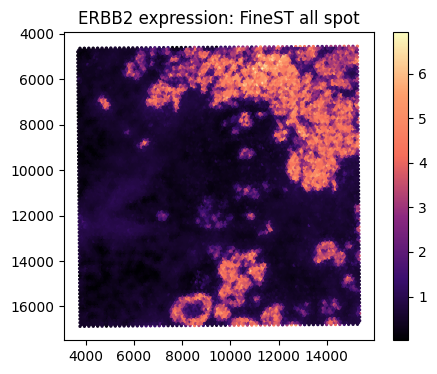

In [28]:
fstplt.gene_expr_allspots('ERBB2', spatial_loc_all, adata_impt_all_reshape, gene_hv, 
                          'FineST all spot', marker='h', s=2.5, 
                           figsize=(5, 4), save_path=f'{demo_data}{fig_path}/ERBB2_expr_imput_allspot.pdf')

5.4 Visualization: gene at all sub-spot

ERBB2 gene expression dim: (1262848, 1)
ERBB2 gene expression: 
 [[0.37140443]
 [0.35478274]
 [0.34206131]
 ...
 [1.68611655]
 [0.84491667]
 [0.98633722]]


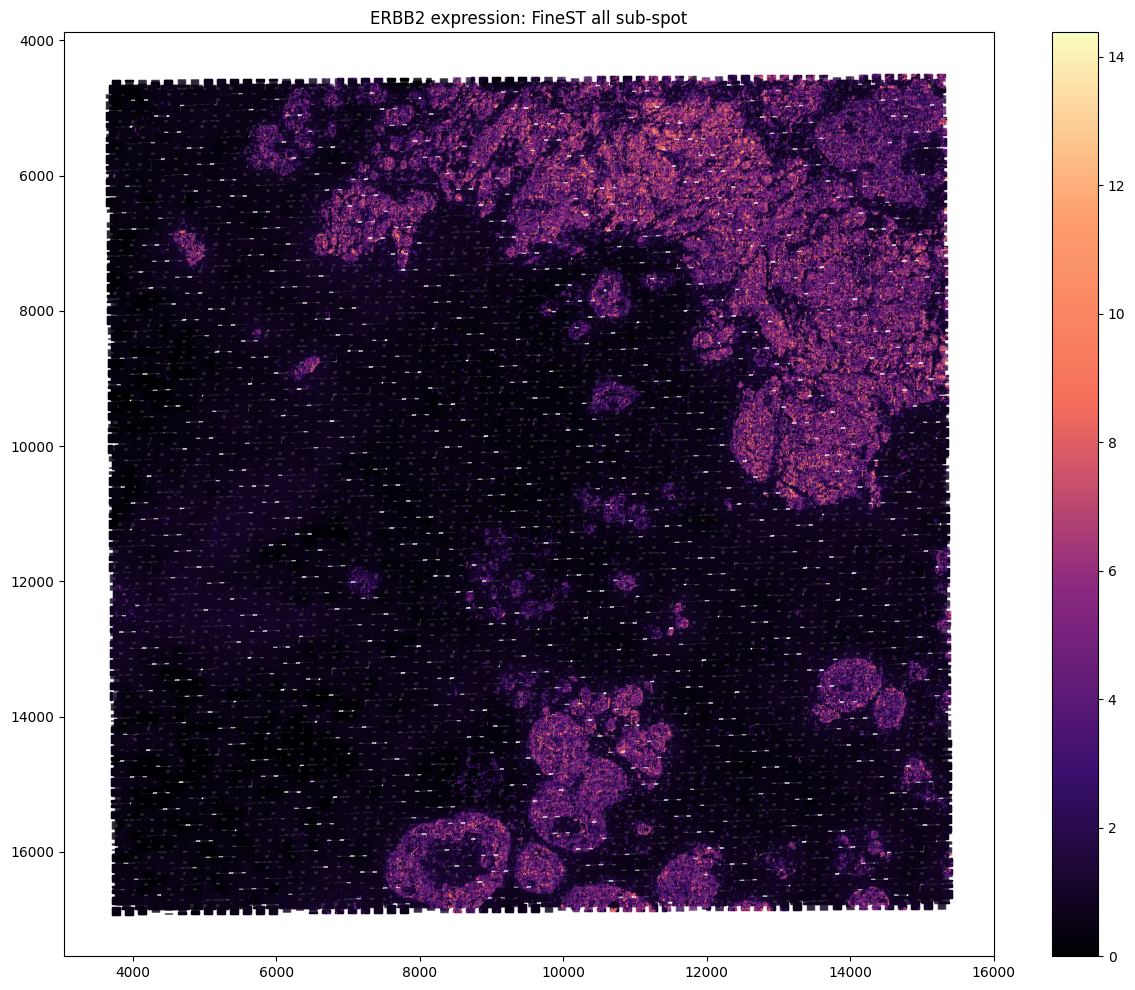

In [29]:
fstplt.gene_expr_allspots('ERBB2', C2, adata_impt_all.X, gene_hv, 
                          'FineST all sub-spot', marker='s', s=0.3, figsize=(15, 12), save_path=None)

In [31]:
#####################
# release GUP memory
#####################
fst.release_gpu_tensors(globals())
# release_gpu_tensors(locals())    # If inside a function or class method

No GPU tensors detected.


## 6. Infer and impute gene expression at "single-cell" level

<div class="alert alert-info">

**Note**
Section 6 directly infers super-resolved gene expression based on image features from ``nuclei segmentation``. The framework is similar to Section 3-5. 
</div>

6.1 Infer the gene expression of at single-cell resolution

In [54]:
dir_name

'/mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Finetune/20250609222943565099'

You can use the `dir_name` just obtained from Section 2 (Model training), but just like Section 3, here we use our trained `dir_name` for paper results repeated (saved in `FineST/FineST/Finetune/20240125140443830148`).

In [13]:
# dir_name = 'logging/20250623164127888297'    # for HV_LR_gene500 
# dir_name = 'logging/20250623194133347124'    # for HV_LR_gene200 
dir_name = 'logging/20250623224015573616'    # for HV_LR_gene100 
# dir_name = 'logging/20250609222943565099'    # for LR_gene 

The image embeddings feature `sc_BRCAhuman_pth_14_14` is based on `_adata_imput_all_spot.adata` from the last section.

conda activate FineST

python FineST/demo/StarDist_nuclei_segmente.py \
        --tissue BRCAhuman \
        --out_dir FineST_local/Dataset/BRCA/StarDist/DataOutput \
        --adata_path FineST_local/Dataset/ImputData/BRCA/BRCA_adata_imput_all_spot.h5ad \
        --img_path FineST_local/Dataset/BRCA/BRCAhuman/GSM7782699_tissue_image.tif 

time python ./FineST/demo/Image_feature_extraction.py \
   --dataset sc_BRCAhuman \
   --position /mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Dataset/BRCA/StarDist/DataOutput/BRCAhuman/_position_all_tissue_sc.csv \
   --imagefile /mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Dataset/BRCA/BRCAhuman/GSM7782699_tissue_image.tif \
   --scale_image False \
   --method Virchow2 \
   --output_path_img /mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Dataset/BRCA/HIPT/sc_BRCAhuman_pth_14_14_image \
   --output_path_pth /mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Dataset/BRCA/HIPT/sc_BRCAhuman_pth_14_14 \
   --patch_size 14 \
   --logging_folder /mnt/lingyu/nfs_share2/Python/FineST/FineST_local/Logging/HIPT_BRCA/

real    23m11.753s
user    22m7.427s
sys     0m40.347s

In [14]:
# file_paths_sc = sorted(os.listdir(str(path) + 'FineST/FineST_local/Dataset/BRCA/HIPT/sc_BRCAhuman_pth_14_14/'))
file_paths_sc = sorted(os.listdir(f'{demo_data}/ImgEmbeddings/sc_pth_14_14/'))
print("Image embedding file: ", file_paths_sc[:2])

## Image patch position
data_all_sc = fst.get_image_coord_all(file_paths_sc)
spatial_loc_sc = pd.DataFrame(data_all_sc, columns=['pixel_y', 'pixel_x'])

## save .csv file
spatial_loc_sc.to_csv(f'{demo_data}{link_data}/position_order_sc.csv', index=False, header=False)

Image embedding file:  ['sc_BRCAhuman_10000.0_5402.0.pth', 'sc_BRCAhuman_10000.264317180618_8751.71325734853.pth']


In [15]:
import glob
image_embed_path_sc = f'{demo_data}/ImgEmbeddings/sc_pth_14_14/*.pth'
spatial_pos_path_sc = f'{demo_data}{link_data}/position_order_sc.csv'

In [16]:
## load models
model = fst.load_model(dir_name, parameter_file_path, gene_hv)   
# model.to(device)

## load all data
all_dataset_sc = fst.build_loaders_inference_allimage(batch_size=len(file_paths_sc),
                                                       file_paths_spot=image_embed_path_sc, 
                                                       spatial_pos_path=spatial_pos_path_sc, 
                                                       dataset_class='VisiumSC')

## inference
logger.info("Running inference tesk single-nuclei...")
start_time = time.time()
(recon_ref_adata_image_f2, 
reconstructed_matrix_reshaped,
representation_image_reshape_between_spot,
input_image_exp_between_spot,
input_coord_all) = fst.perform_inference_image_between_spot(model, all_dataset_sc, dataset_class='VisiumSC')
print("--- %s seconds ---" % (time.time() - start_time))

## print
print("recon_ref_adata_image_f2 shape:", recon_ref_adata_image_f2.shape)
logger.info("Running inference tesk single-nuclei DONE!")

CUDA is available. GPU: NVIDIA A100-PCIE-40GB
***** Building loaders_inference sc image *****


[2025-06-25 21:37:32] INFO - Running inference tesk single-nuclei...


Finished loading all files
***** Finished building loaders_inference *****
device cuda:0
***** Begin perform_inference: ******


100%|████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


***** batch_size=adata.shape[0] *****
torch.Size([56794, 1, 1280])
1
Finished extractting image_between_spot data


[2025-06-25 21:37:35] INFO - Running inference tesk single-nuclei DONE!


--- 2.2486371994018555 seconds ---
recon_ref_adata_image_f2 shape: (56794, 957)


In [17]:
spatial_loc_sc = fst.get_allspot_coors(input_coord_all)
reconstructed_matrix_reshaped_tensor, _ = fst.reshape_latent_image(reconstructed_matrix_reshaped, 
                                                                   dataset_class='VisiumSC')
(_, _, all_spot_all_variable, 
 C2, adata_infer_sc) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor,
                                                    spatial_loc_sc, gene_hv, patch_size=14, dataset_class="VisiumSC")

Are there any duplicate rows? : False
pixel_step (half of patch_size): 7.0


In [18]:
# adata_smooth_sc = fst.impute_adata(adata, adata_infer_sc, C2, gene_hv, dataset_class='VisiumSC', weight_exponent=2)
adata_smooth_sc = fst.impute_adata(adata_norml, adata_infer_sc, C2, gene_hv, dataset_class='VisiumSC', weight_exponent=2)
adata_impt_sc, data_impt_sc = fst.weight_adata(adata_infer_sc, adata_smooth_sc, gene_hv, w=0.8)
print(adata_impt_sc)

## save adata
adata_impt_sc.write_h5ad(f'{demo_data}{save_data}adata_imput_all_sc.h5ad')    # adata: 40068 × 596

Smoothing time: 19.7416 seconds
AnnData object with n_obs × n_vars = 56794 × 957
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'


ERBB2 gene expression dim: (56794, 1)
ERBB2 gene expression: 
 [[0.48190308]
 [2.217909  ]
 [1.9529791 ]
 ...
 [1.5364244 ]
 [2.1493435 ]
 [3.636919  ]]


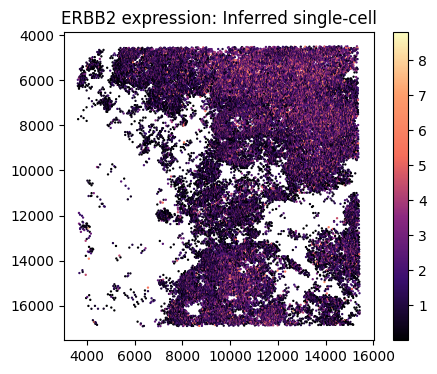

In [19]:
fstplt.gene_expr_allspots('ERBB2', spatial_loc_sc, recon_ref_adata_image_f2, gene_hv, 
                          'Inferred single-cell', s=0.6, 
                         figsize=(5, 4), save_path=f'{demo_data}{fig_path}/ERBB2_expr_infer_allsc.pdf')

ERBB2 gene expression dim: (56794, 1)
ERBB2 gene expression: 
 [[1.43793022]
 [2.19336902]
 [2.15616819]
 ...
 [2.15687495]
 [1.90660255]
 [4.00333045]]


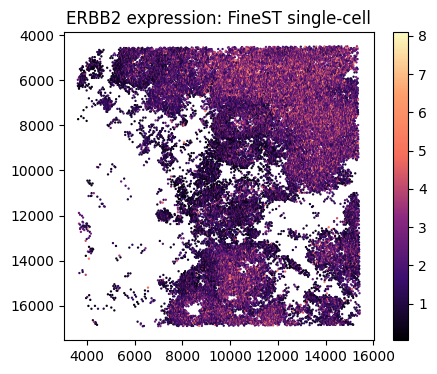

In [20]:
## Save imputed expression
_, adata_impt_sc_reshape = fst.reshape_latent_image(data_impt_sc, dataset_class='VisiumSC')

fstplt.gene_expr_allspots('ERBB2', spatial_loc_sc, adata_impt_sc_reshape, gene_hv, 
                          'FineST single-cell', s=0.6, 
                         figsize=(5, 4), save_path=f'{demo_data}{fig_path}/ERBB2_expr_imput_allsc.pdf')

## map subspot to nuclei 

In [21]:
import os
path = '/mnt/lingyu/nfs_share2/Python/'

In [25]:
import numpy as np
import scanpy as sc
import pandas as pd

demo_data = 'BRCAhuman_data/' 
save_data = 'SaveData_HVLR/'
adata_impt_all_subspot = sc.read_h5ad(f'{demo_data}{save_data}adata_imput_all_subspot.h5ad')    
adata_impt_all_sc = sc.read_h5ad(f'{demo_data}{save_data}adata_imput_all_sc.h5ad')  
print(adata_impt_all_subspot)
print(adata_impt_all_sc)

AnnData object with n_obs × n_vars = 1262848 × 957
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 56794 × 957
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'


In [27]:
import scanpy as sc
from scipy.spatial import cKDTree

def map_subspot_to_nuclei(adata_subspot, adata_nuclei, spatial_key="spatial", inherit_uns_from="subspot"):
    """
    Map each subspot to its nearest nuclei and keep unique mappings.
    Also copy the .uns["spatial"] from one AnnData to the new AnnData.

    Parameters
    ----------
    adata_subspot : AnnData
        AnnData object containing subspot data (to be mapped).
    adata_nuclei : AnnData
        AnnData object containing nuclei data (reference).
    spatial_key : str
        Key in obsm for spatial coordinates.
    inherit_uns_from : str
        Either "subspot" or "nuclei". Determines from which AnnData to inherit .uns["spatial"].

    Returns
    -------
    adata_map : AnnData
        AnnData object with only the uniquely mapped subspots, 
        including spatial coordinates and .uns["spatial"] info.
    """
    ## Build tree for nuclei coordinates, find nearest nuclei index for each subspot
    tree = cKDTree(adata_nuclei.obsm[spatial_key])
    _, closest_indices = tree.query(adata_subspot.obsm[spatial_key], k=1)
    
    ## Get the corresponding coordinates of mapped nuclei, Keep only unique mappings
    mapped_coords = adata_nuclei.obsm[spatial_key][closest_indices]
    _, unique_idx = np.unique(mapped_coords, axis=0, return_index=True)
    
    #W Construct new AnnData object with unique mappings
    adata_map = sc.AnnData(
        adata_subspot.X[unique_idx],
        var=adata_subspot.var.copy(),
        obs=adata_subspot.obs.iloc[unique_idx].copy()
    )
    adata_map.obsm[spatial_key] = mapped_coords[unique_idx]
    adata_map.var_names = adata_subspot.var_names

    # Copy .uns["spatial"]
    if inherit_uns_from == "subspot":
        adata_map.uns["spatial"] = adata_subspot.uns["spatial"].copy()
    elif inherit_uns_from == "nuclei":
        adata_map.uns["spatial"] = adata_nuclei.uns["spatial"].copy()
    else:
        raise ValueError("inherit_uns_from must be 'subspot' or 'nuclei'.")

    return adata_map

In [28]:
adata_map = map_subspot_to_nuclei(adata_impt_all_subspot, adata_impt_all_sc)
print(adata_map)

AnnData object with n_obs × n_vars = 56489 × 957
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'
